In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from PIL import Image
from scipy.stats import logistic


# Name of the hdf file that contain the data we need
f_name = 'sxro6416-r0504.h5'

# Open the hdf5 file, use the path to the images to extrate the data and place
# it in the image data object for further manipulation and inspection.
datafile = h5py.File(f_name, 'r')
image_data = []
for i in itertools.count(start=0):
    d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
    if d is not None:
        # actual image is at first index
        image_data.append(d[0])
    else:
        break

#print(image_data[1])
# Tell me how many images were contained in the datafile
print(f"loaded {len(image_data)} images")


#for i in range(20):
    #plt.imshow(image_data[i])
    #plt.savefig('image'+str(i)+'.png',dpi=1000)
    #image = Image.fromarray(image_data[i]).convert("L")
    #image.save("image"+str(i)+".png")

# Plot a good dataset - here index 8 (but there are others too!)
#misc.imshow(image_data[0])
#misc.show()

#image = Image.fromarray(image_data[0]).convert("L")
#image.save("out.png")

# The histogram of the data will help show possible single photon hits
plt.hist(image_data[1].flatten(), bins=100)
plt.yscale('log')


loaded 20 images


In [249]:
dat=image_data[1]
#This is a test program. All codes will be run on this test data, extracted from image #1.
test_dat=dat[242:262,1246:1288].astype(int)-50
test_dat_2=dat[492:525,1308:1340].astype(int)-50

In [255]:
class tag:
    'used to tag SPEs.'
    lx=0
    ly=0
    rx=0
    ry=0
    width=0
    height=0
    
    def __init__(self,lx,ly,rx,ry):
        self.lx=lx
        self.ly=ly
        self.rx=rx
        self.ry=ry
        self.width=rx-lx
        self.height=ry-ly
    
    def param(self):
        return [self.lx,self.ly,self.rx,self.ry]
    
    def hw(self):
        return [self.height,self.width]
    
def thresholding(dataset,threshold):
    label_matrix=np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            if(dataset[i,j]>=threshold):
                label_matrix[i,j]=1
    return label_matrix
    
from copy import deepcopy
    
def boxing(thres_matrix):
    lm=deepcopy(thres_matrix);

    def search(x,y):
        lefttop_x=x-1
        lefttop_y=y-1
        rightbot_x=x+1
        rightbot_y=y+1
        if(lm[x,y]==0):
            return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
        else:
            lm[x,y]=0
        for i in [x-2,x-1,x,x+1,x+2]:
            for j in [y-2,y-1,y,y+1,y+2]:
                if((i>=lm.shape[0]) or (j>=lm.shape[1])):
                    continue
                elif(lm[i,j]==1):
                    [a,b,c,d]=search(i,j)
                    #print([a,b,c,d])
                    lm[i,j]=0
                    lefttop_x=min([lefttop_x,a])
                    lefttop_y=min([lefttop_y,b])
                    rightbot_x=max([rightbot_x,c])
                    rightbot_y=max([rightbot_y,d])
                    #print('a',[lefttop_x,lefttop_y,rightbot_x,rightbot_y])
       
        return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
    #[lx,ly,rx,ry]=search(17,20,lm)
    #thres_matrix[lx,ly]=2
    #thres_matrix[rx,ry]=2
    #plt.imshow(thres_matrix)
    
    
    tag_list=[]
    
    flag=0

    while(True):
        for i in range(thres_matrix.shape[0]):
            for j in range(thres_matrix.shape[1]):
                if(lm[i,j]==1):
                    flag=1
                    [lx,ly,rx,ry]=search(i,j)
                    thres_matrix[lx,ly]=2
                    thres_matrix[rx,ry]=2
                    t=tag(lx,ly,rx,ry)
                    tag_list.append(t)
                    break
            if(flag==1):
                break
        if(flag==0):
            break
        flag=0
    plt.imshow(thres_matrix)
    return tag_list



[[-3  4  1]
 [ 1 37 29]
 [18 41 12]
 [-4  3  2]]


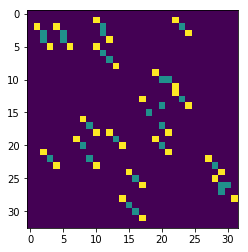

In [257]:
l2=thresholding(test_dat_2,30)
l1=thresholding(test_dat,30)

tag_list=boxing(deepcopy(l2))

p=(tag_list[0].param())

test_test_dat=test_dat_2[p[0]:p[2]+1,p[1]:p[3]+1]
print(test_test_dat)

In [245]:
test_dat_2[22:25,27:30]

array([[ 3, 14,  7],
       [11, 39, 22],
       [12,  7, 10]])

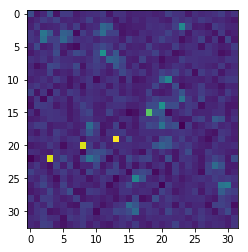

In [258]:
plt.imshow(test_dat_2)